# Working with Geospatial Hydrologic Data Using Web Services

*Dam Impact on streamflow: Python*

| Author | Affiliation |
| ------- | ----------- |
| Taher Chegini | University of Houston |
| Mike Johnson | [Lynker](https://www.lynker.com/solutions/water-environmental-resources/) |
| Marc Weber |  US Environmental Protection Agency |

## Introduction

This is the second part of the "Working with Geospatial Hydrologic Data Using Web Services" workshop. In the [first part](https://mikejohnson51.github.io/IOW2022_R/slides.html), we covered some basic concepts related to geospatial analysis. Although R is used in the first part, the introduced concepts are applicable to Python as well. So, in this tutorial, we won't repeat the same concepts, instead we focus on equivalent tools in Python and provide an in-depth hands-on example geospatial analysis workflow.

## Geospatial Tools in Python

This is non-exhaustive list of geospatial tools that we directly/indirectly use in this tutorial:

* [PyNHD](https://docs.hyriver.io/en/latest/readme/pynhd.html): Navigate and subset NHDPlus (MR and HR) dataset using web services.
* [Py3DEP](https://docs.hyriver.io/en/latest/readme/py3dep.html): Access topographic data through National Map's 3DEP web service.
* [PyGeoHydro](https://docs.hyriver.io/en/latest/readme/pygeohydro.html): Access NWIS, NID, WQP, HCDN 2009, NLCD, CAMELS, and SSEBop databases.
* [PyDaymet](https://docs.hyriver.io/en/latest/readme/pydaymet.html): Access Daymet for daily climate data both single pixel and gridded.
* [xarray](https://xarray.pydata.org/en/stable/): An open-source project and Python package that makes working with labeled multi-dimensional arrays simple, efficient, and fun!
* [rioxarray](https://corteva.github.io/rioxarray/stable/index.html): Rasterio xarray extension.
* [GeoPandas](https://geopandas.org/en/stable/): An open-source project to make working with geospatial data in python easier.
* [Folium](https://python-visualization.github.io/folium/): Makes it easy to visualize data that's been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations and passing rich vector/raster/HTML visualizations as markers on the map.

You can find more geospatial tools at [Awesome Geospatial](https://github.com/sacridini/Awesome-Geospatial) repository.

The primary goal of this hands-on tutorial is to introduce a handful of geospatial web services for conducting scientific studies. For this purpose, we're going to take a look at the impact of building dams on their downstream streamflow. Here are some example peer-reviewed papers on this topic.

- [Non-stationary flood frequency analysis in continental Spanish rivers, using climate and reservoir indices as external covariates](https://doi.org/10.5194/hess-17-3189-2013)
- [Nonlinear Filtering Effects of Reservoirs on Flood Frequency Curves at the Regional Scale](https://doi.org/10.1002/2017WR020871)

We set the area of interest (AOI) to Texas and study dams that have been built in the 1995-2005 period.

Workflow:

- Get gauge stations within Texas that have enough streamflow data
- Get dams within Texas that have been built have been built between 1995-2005
- Filter out stations that don't have any dams in their upstream up to 10 km
- Get streamflow data for the remaining stations
- Visually inspect the streamflow data for dam impacts
- Check land use/land cover type around the dams

## Streamflow Gauges

First, we use the National Water Information System (NWIS) service to check streamflow data availability in our AOI and 10 years before and after the period of our study, i.e., the 1985-2015 period.

Let's start by importing the required libraries.

In [1]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pygeohydro as gh
import pygeoutils as geoutils
from pygeohydro import NID, NWIS
from pynhd import NLDI, GeoConnex, WaterData
from pynhd.exceptions import ZeroMatchedError

In [2]:
start = "1985-01-01"
end = "2015-01-01"
texas = gh.helpers.get_us_states("TX")

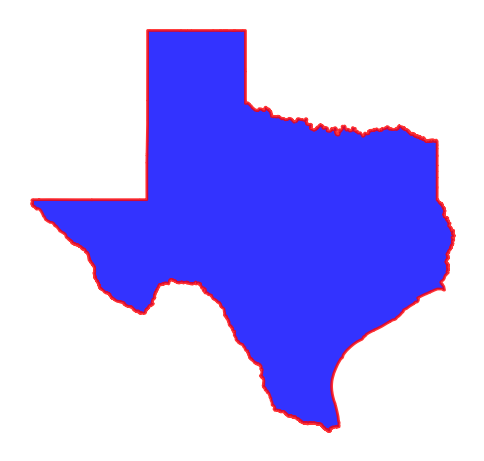

In [3]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
ax.set_axis_off()

In [4]:
nwis = NWIS()
query = {
    "stateCd": "TX",
    "startDt": start,
    "endDt": end,
    "outputDataTypeCd": "dv",  # daily values
    "hasDataTypeCd": "dv",  # daily values
    "parameterCd": "00060",  # discharge
}
sites = nwis.get_info(query)

We want to further filter the stations based on thier drainage area and only keep the stations with drainage area greater than 10 km$^2$. For this purpose, we can use GeoConnex API to get the drainage area of the stations.

In [5]:
area = GeoConnex("gages").byid("provider_id", sites["site_no"].tolist())
area = area[["provider_id", "nhdpv2_totdasqkm"]].set_index("provider_id")["nhdpv2_totdasqkm"]
area.name = "nhd_areasqkm"
sites = sites.merge(area, left_on="site_no", right_index=True)

We can check the number of streamflow gauge stations in Texas that fit this criterion, using:

In [6]:
sites.shape[0]

3630

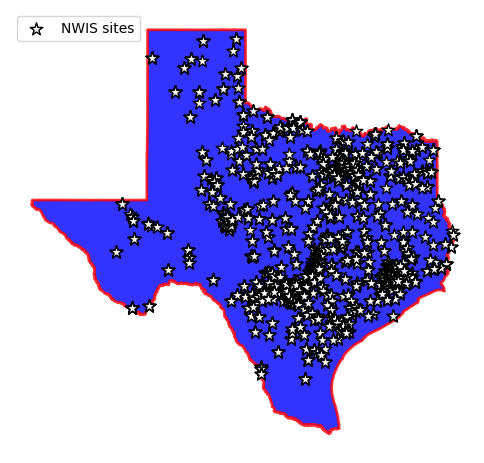

In [7]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

Now, let's filter these stations a step further to include only those stations that have around 30 years of daily streamflow data with drainage area of larger than 10 km$^2$ that have been impacted by human activities.

In [8]:
sites = sites[
    (sites.parm_cd == "00060")  # discharge
    & (sites.stat_cd == "00003")  # mean
    & (sites.count_nu >= 30 * 365)  # at least 30 years of data
    & ~sites.hcdn_2009  # not pristine
    & (sites.nhd_areasqkm > 10)
].copy()
sites.shape[0]

321

Upon applying this filter, we're left with 280 stations.

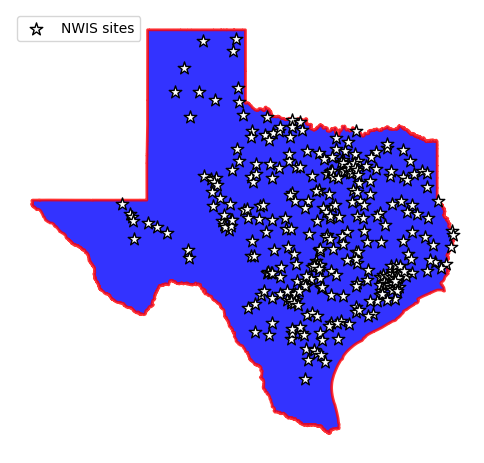

In [9]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

## Dams

Next, we need to retrieve the dams in Texas that have been built between 1995 and 2005. We use National Inventory of Dams (NID) web service for this purpose. First, let's check out the fields that NID exposes through their web service.

In [10]:
nid = NID()
nid.valid_fields[nid.valid_fields.str.contains("year", case=False)]

55                yearCompleted
56              yearCompletedId
57                yearsModified
176        hydroApprovedIdfYear
181    hydroOrigIdfApprovedYear
186        hydroPmfApprovedYear
192           hydroOtAepDevYear
198            hydroTopInfoYear
256     dsoPiExtensionTenYearId
Name: name, dtype: object

In [11]:
nid.valid_fields[nid.valid_fields.str.contains("state", case=False)]

16                stateFedId
19                     state
21               countyState
27          stateRegulatedId
29     stateRegulatoryAgency
91                 cityState
249                 stateKey
Name: name, dtype: object

Based on these, we should use the ``stateKey`` and ``yearCompleted`` fields.

In [12]:
dam_list = nid.get_byfilter(
    [
        {
            "stateKey": ["TX"],
            "yearCompleted": ["[1995 2005]"],
        },
    ],
)
dams = dam_list[0]

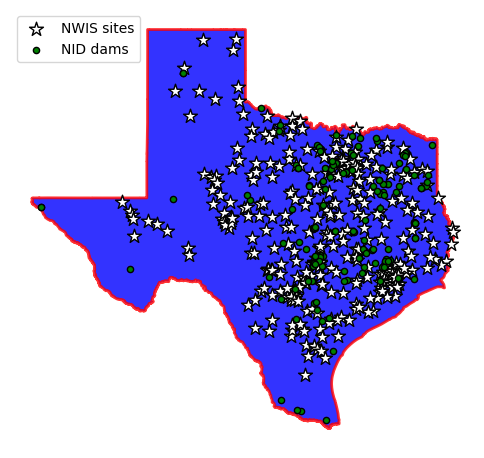

In [13]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

As is evident from the plot above, there are many stations that don't have any dams in their vicinity. One way to eliminate these stations is using a spatial query based on a search radius. We can determine an estimation for our search radius based on the upstream drainage area distribution of the streamflow gauges.

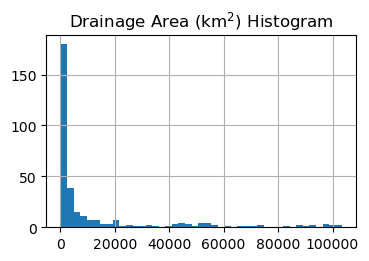

In [14]:
ax = sites.hist("nhd_areasqkm", figsize=(4, 2.5), bins="auto")
_ = ax[0][0].set_title("Drainage Area (km$^2$) Histogram")

We can see that most stations have a drainage area of less than 15000 km$^2$. Since they're not very large a search radius of 10 km should be sufficient. Now, we define a function that carries out an efficient spatial query to find the stations that have at least one dam within a 10-km radius.

In [15]:
def distance_filter(gdf1, gdf2, dist_km):
    """Filter gdf1 to only include points within distance of gdf2."""
    buff = gdf1.to_crs(5070).buffer(dist_km * 1e3)
    idx2, idx1 = buff.sindex.query(gdf2.to_crs(5070).geometry)
    return gdf1.iloc[pd.unique(idx1)].reset_index(drop=True), gdf2.iloc[
        pd.unique(idx2)
    ].reset_index(drop=True)

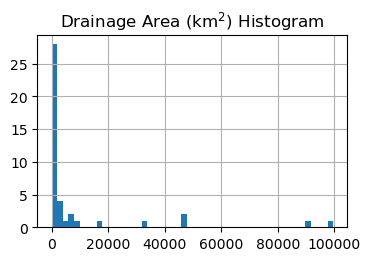

In [16]:
sites, dams = distance_filter(sites, dams, 10)

ax = sites.hist("nhd_areasqkm", figsize=(4, 2.5), bins="auto")
_ = ax[0][0].set_title("Drainage Area (km$^2$) Histogram")

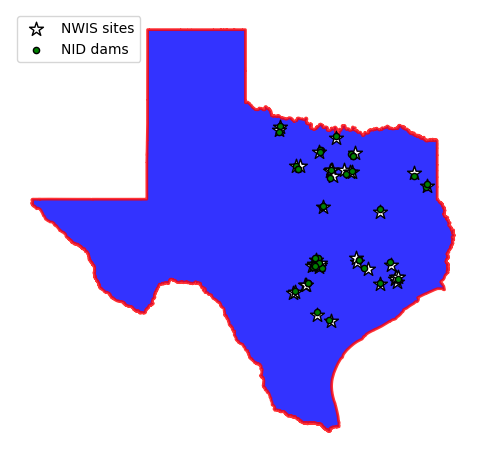

In [17]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

## Flowlines and Hydrolinking

So far, we obtained only the stations that have at least one dam in their 10-km radius, but we didn't find if those dams are in their upstream or downstream. We use the Hydro Network-Linked Data Index (NLDI) web service to obtain the upstream flowlines of the streamflow gauges up to 10 km. Note that this 10 km is the distance along the flowlines.

In [18]:
nldi = NLDI()

In [19]:
flw_up = {}
noflw = []
for agency, fid in sites[["agency_cd", "site_no"]].itertuples(index=False, name=None):
    try:
        flw_up[fid] = nldi.navigate_byid(
            fsource="nwissite",
            fid=f"{agency}-{fid}",
            navigation="upstreamTributaries",
            source="flowlines",
            distance=10,
        )
    except ZeroMatchedError:
        noflw.append(fid)
noflw

[]

In [20]:
sites = sites[sites.site_no.isin(flw_up)].copy()
sites, dams = distance_filter(sites, dams, 10)

We now have flowlines and dams that are closer than 10 km, but we still don't have a way of linking these features. For this purpose, we use NHDPlus's Common Identifier (`comid`). One way to obtain the first downstream flowline of coordinate is to use NLDI's `hydrolocation` endpoint.

In [21]:
coords = list(dams[["longitude", "latitude"]].astype(float).itertuples(index=False, name=None))
nid_comids = nldi.feature_byloc(coords)
dams["nhdplus_comid"] = nid_comids.comid.values

In [22]:
coords = list(sites[["dec_long_va", "dec_lat_va"]].astype(float).itertuples(index=False, name=None))
site_comids = nldi.feature_byloc(coords)
sites["nhdplus_comid"] = site_comids.comid.values

We can then use these obtained comids to hydrolink the dams, stations, and flowlines.

In [23]:
flw_all = pd.concat(flw_up.values(), keys=flw_up.keys()).reset_index().drop(columns="level_1")
flw_all = gpd.GeoDataFrame(
    flw_all.rename(columns={"level_0": "usgs_id"}), crs=flw_up["07312200"].crs
)
flw_all.head()

,usgs_id,geometry,nhdplus_comid
0,08044000,"LINESTRING (-97.69269 33.23604, -97.69307 33.2...",1305635
1,08044000,"LINESTRING (-97.69154 33.23755, -97.69228 33.2...",1305593
2,08044000,"LINESTRING (-97.71624 33.23529, -97.71599 33.2...",1305595
3,08044000,"LINESTRING (-97.69438 33.24547, -97.69389 33.2...",1305591
4,08044000,"LINESTRING (-97.69002 33.24999, -97.68994 33.2...",1305589


Finally, upon hydrolinking these features we can determine the stations that have at least one dam in their upstream up to 10 km.

In [24]:
flw_dam = pd.merge(
    flw_all[["usgs_id", "nhdplus_comid"]],
    dams[["federalId", "nhdplus_comid"]].rename(columns={"federalId": "dam_id"}),
    on="nhdplus_comid",
    how="left",
)
flw_dam = flw_dam[~flw_dam.dam_id.isna()].reset_index(drop=True)
flw_dam

,usgs_id,nhdplus_comid,dam_id
0,08178700,10839872,TX07211
1,08158920,5781345,TX07223
2,08158920,5781345,TX07494
3,08095000,5531532,TX07074
4,08095000,5531532,TX07061
5,08057445,1260363,TX09216
6,07312200,13730353,TX07042
7,07312110,13734222,TX07025
8,08177300,1638809,TX07200


In [25]:
site_dam = flw_dam.usgs_id.unique()
site_dam

array(['08178700', '08158920', '08095000', '08057445', '07312200',
       '07312110', '08177300'], dtype=object)

## Streamflow Observations

Upon finalizing the stations that satisfy our criteria, we use NWIS to obtain the daily streamflow data. But first, we need to obtain the year that the construction of dams were completed, so we can exactly specify the required streamflow data period.

In [26]:
dams_info = nid.inventory_byid(flw_dam.dam_id.to_list())
dams_info.head()

,associatedStructuresCount,conditionAssessDate,conditionAssessDetail,conditionAssessId,damHeight,damLength,distance,drainageArea,eapId,dsacAssignedDate,...,lastEapExcerDate,dataUpdated,usaceDistrict,noConsequencesId,secretaryAgricultureBuiltId,nrcsWatershedAuthorizationId,isAssociatedStructureId,fedRegulatedId,inundationNidAddedId,geometry
id,,,,,,,,,,,,,,,,,,,,,
544499,0,2014-06-18T12:00:00.000Z,NOT RATED,5,22,0,NaN,1.13,3,None,...,None,2024-09-10T12:00:00.000Z,Fort Worth District,0,0,5,No,No,0,POINT (-97.3783 28.7772)
544213,0,2020-09-30T12:00:00.000Z,SATISFACTORY,1,47,1300,NaN,0.36,1,None,...,None,2024-09-10T12:00:00.000Z,Fort Worth District,0,0,5,No,No,0,POINT (-97.60174 31.78104)
543855,0,2014-06-18T12:00:00.000Z,NOT RATED,5,27,0,NaN,0.20,3,None,...,None,2024-09-10T12:00:00.000Z,Fort Worth District,0,0,5,No,No,0,POINT (-98.91696 33.92299)
542221,0,2024-03-20T12:00:00.000Z,POOR,5,26,730,0.0,1.34,1,None,...,None,2024-09-10T12:00:00.000Z,Galveston District,0,0,5,No,No,0,POINT (-97.89934 30.24614)
542209,0,2021-04-30T12:00:00.000Z,SATISFACTORY,2,49,6615,0.0,16.72,1,None,...,None,2024-09-10T12:00:00.000Z,Galveston District,0,1,3,No,No,0,POINT (-98.45066 29.55025)


We use the `yearCompleted` field to determine the required study period by looking at 15 years before and after the year completed for each dam. The reason that we opted for 15 years is the fact that during the construction the streamflow is temporarily diverted from its original path and also upon completion it usually takes some time for dams to be filled and reach their operational capacity. So we consider a 5-year buffer around the year completed.

In [27]:
flw_dam = pd.merge(
    flw_dam,
    dams_info[["federalId", "nidStorage", "nidHeight", "yearCompleted"]].rename(
        columns={"federalId": "dam_id"}
    ),
    on="dam_id",
    how="left",
)
flw_dam["start"] = pd.to_datetime(flw_dam.yearCompleted - 15, format="%Y")
flw_dam["end"] = pd.to_datetime(flw_dam.yearCompleted + 15, format="%Y") + pd.DateOffset(
    years=1, days=-1
)
flw_dam.head()

,usgs_id,nhdplus_comid,dam_id,nidStorage,nidHeight,yearCompleted,start,end
0,08178700,10839872,TX07211,8741.00,53,2004,1989-01-01,2019-12-31
1,08158920,5781345,TX07223,156.31,26,1999,1984-01-01,2014-12-31
2,08158920,5781345,TX07494,189.00,28,1996,1981-01-01,2011-12-31
3,08095000,5531532,TX07074,731.00,73,2000,1985-01-01,2015-12-31
4,08095000,5531532,TX07061,410.00,23,1998,1983-01-01,2013-12-31


We then use these dates to obtain the streamflow.

In [28]:
dates = (flw_dam.start.min(), flw_dam.end.max())
qobs = nwis.get_streamflow(site_dam, dates)

Now, let's take a look at the data and assess the station by visual inspection. Note the there are several methods for quantifying the impact of dams on streamflow such as Reservoir Index, but in this tutorial we just rely on visual inspection for brevity.

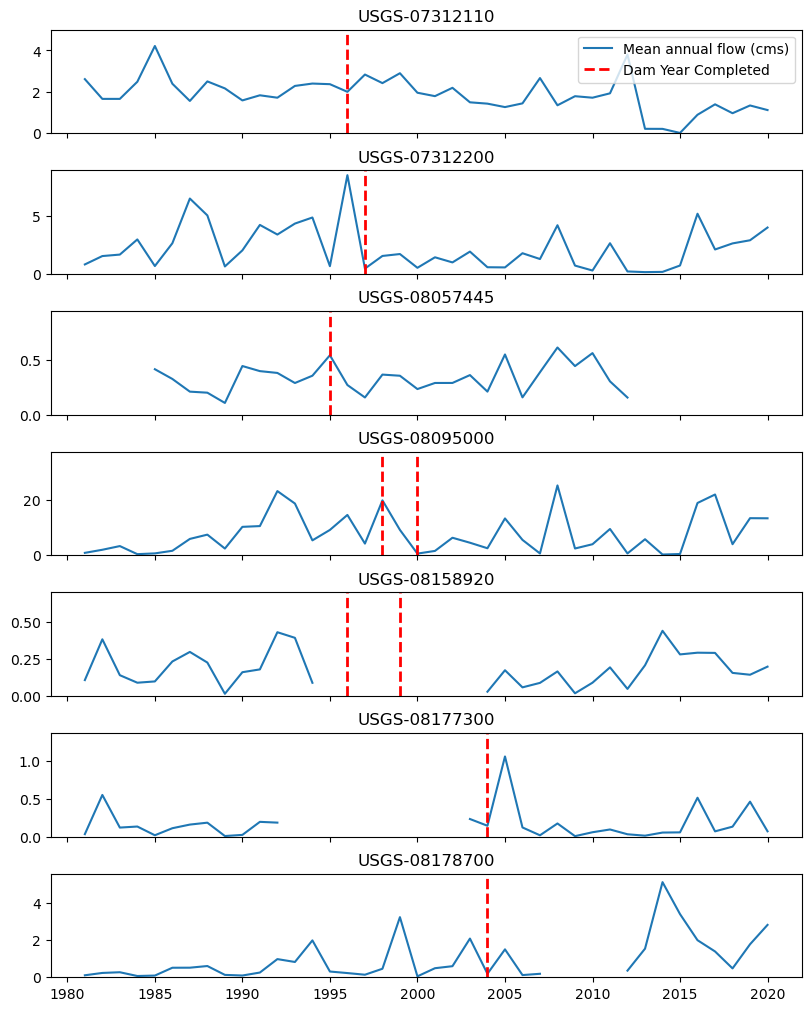

In [29]:
ma = qobs.groupby(pd.Grouper(freq="YE")).mean()
yc = flw_dam.set_index("usgs_id").yearCompleted
fig, axs = plt.subplots(
    nrows=ma.shape[1], figsize=(8, 10), sharex=True, constrained_layout=True, dpi=100
)

for i, s in enumerate(ma):
    (line1,) = axs[i].plot(ma[s], label="Mean annual flow (cms)")
    axs[i].set_ylim(0, ma[s].quantile(0.95) * 1.7)
    axs[i].set_title(s)
    yrs = yc.loc[s.replace("USGS-", "")]
    yrs = [yrs] if np.isscalar(yrs) else yrs
    for yr in yrs:
        line2 = axs[i].axvline(
            pd.to_datetime(yr, format="%Y"),
            color="r",
            linestyle="--",
            linewidth=2,
            label="Dam Year Completed",
        )
_ = axs[0].legend(handles=[line1, line2], loc="best")

We can see that based on the available data and visual inspection, the first station shows a noticeable difference before and after the dam construction. Next we take a closer look at this station, `USGS-07312200`.

## Land Use/Land Cover (LULC)

To gain a better understanding of the land features around and near the `USGS-07312200` station and its dams, we use the LULC data. For this purpose, first, we obtain the local catchments up to 30 km upstream and downstream of the station. The WaterData web service has several layers one of which is local catchments. Let's use the COMIDs to obtain their corresponding catchments.

In [30]:
station_id = "07312200"
flw_ut = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=30,
)
flw_dd = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="downstreamDiversions",
    source="flowlines",
    distance=30,
)
flowlines = gpd.GeoDataFrame(pd.concat([flw_ut, flw_dd]), crs=4326)
wd = WaterData("catchmentsp")
catchment = wd.byid("featureid", flowlines.nhdplus_comid.to_list())
flw_dd["nhdplus_comid"] = flw_dd.nhdplus_comid.astype(catchment.featureid.dtype)
catchment["direction"] = "upstream"
catchment.loc[catchment.featureid.isin(flw_dd.nhdplus_comid), "direction"] = "downstream"
catchment.head()

,geometry,gridcode,featureid,sourcefc,areasqkm,shape_length,shape_area,direction
0,"MULTIPOLYGON (((-98.95702 34.00904, -98.95757 ...",1347768,13728581,NHDFlowline,3.667051,0.082690,3.579443e-04,upstream
1,"MULTIPOLYGON (((-98.95302 34.00727, -98.95292 ...",1347933,13728583,NHDFlowline,0.005346,0.003188,5.217419e-07,upstream
2,"MULTIPOLYGON (((-98.95483 34.00319, -98.95537 ...",1348044,13728585,NHDFlowline,0.150286,0.018680,1.466643e-05,upstream
3,"MULTIPOLYGON (((-98.94654 34.00018, -98.94817 ...",1347921,13728587,NHDFlowline,0.010543,0.004362,1.028886e-06,upstream
4,"MULTIPOLYGON (((-98.94831 34.0039, -98.94784 3...",1347981,13728589,NHDFlowline,0.142392,0.027063,1.389548e-05,upstream


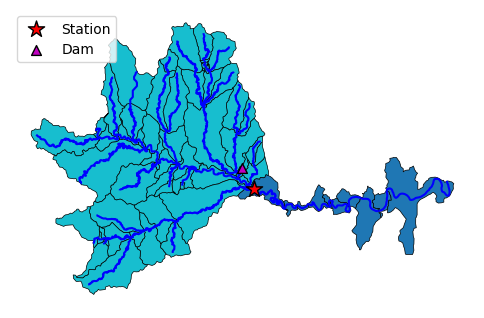

In [31]:
_, ax = plt.subplots(dpi=100, figsize=(6, 6))
catchment.plot(ax=ax, column="direction", edgecolor="k", lw=0.5)
flowlines.plot(ax=ax, color="b", linewidth=1.5, zorder=1)
sites[sites.site_no.isin([station_id])].plot(
    ax=ax, edgecolor="k", c="r", marker="*", markersize=150, label="Station"
)
dams[dams.nhdplus_comid.isin(flowlines.nhdplus_comid)].plot(
    ax=ax, edgecolor="k", c="m", marker="^", markersize=50, label="Dam"
)
ax.legend(loc="upper left")
ax.set_axis_off()

Now, we can retrieve the LULC data at 30-m resolution within the union of these catchments using the Multi-Resolution Land Characteristics (MRLC) Consortium web service.

In [32]:
geom = gpd.GeoSeries([catchment.union_all()], crs=catchment.crs, index=[station_id])
nlcd = gh.nlcd_bygeom(geom, 30, years={"cover": 2019})[station_id]
nlcd

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 1258, y: 804)
Coordinates:
  * x            (x) float64 10kB -99.12 -99.12 -99.12 ... -98.71 -98.71 -98.71
  * y            (y) float64 6kB 34.04 34.04 34.04 34.04 ... 33.82 33.82 33.82
    spatial_ref  int64 8B 0
Data variables:
    cover_2019   (y, x) uint8 1MB 127 127 127 127 127 ... 127 127 127 127 127
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255
    nodatavals:              (255,)

In [33]:
meta = gh.helpers.nlcd_helper()
pd.Series(meta["classes"])

11     Open Water - All areas of open water, generall...
12     Perennial Ice/Snow - All areas characterized b...
21     Developed, Open Space - Includes areas with a ...
22     Developed, Low Intensity -Includes areas with ...
23     Developed, Medium Intensity - Includes areas w...
24     Developed, High Intensity - Includes highly de...
31     Barren Land (Rock/Sand/Clay) - Barren areas of...
41     Deciduous Forest - Areas dominated by trees ge...
42     Evergreen Forest - Areas dominated by trees ge...
43     Mixed Forest - Areas dominated by trees genera...
45     Shrub-Forest - Areas identified as currently s...
46     Herbaceous-Forest - Areas identified as curren...
51     Dwarf Scrub - Alaska only areas dominated by s...
52     Shrub/Scrub - Areas dominated by shrubs; less ...
71     Grassland/Herbaceous - Areas dominated by gram...
72     Sedge/Herbaceous - Alaska only areas dominated...
73     Lichens - Alaska only areas dominated by fruti...
74     Moss - Alaska only areas

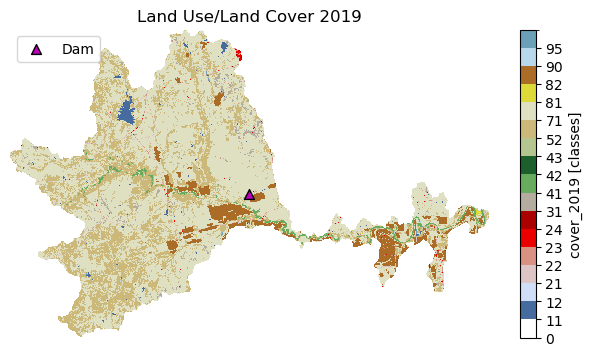

In [34]:
cmap, norm, levels = gh.plot.cover_legends()
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
cover = nlcd.cover_2019.where(nlcd.cover_2019 != nlcd.cover_2019.rio.nodata)
cover.plot(ax=ax, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Land Use/Land Cover 2019")
dams[dams.nhdplus_comid.isin(flw_up[station_id].nhdplus_comid)].plot(
    ax=ax, edgecolor="k", c="m", marker="^", markersize=50, label="Dam"
)
ax.legend(loc="upper left")
ax.set_axis_off()

fig.savefig(Path("_static", "dam_impact.png"), bbox_inches="tight", facecolor="w")

Now, let's take a look at the differences in land cover types, upstream and downstream of the station. We use `cover_statistics` function of [PyGeoHydro](https://github.com/hyriver/pygeohydro) to get the statistics for each land cover types. For this purpose, first we need to mask the NLCD dataset based on the `direction` attribute of the `catchment` geo-dataframe using `xarray_geomask` function from [PyGeoUtils](https://github.com/hyriver/pygeoutils).

In [35]:
ut_geom = catchment[catchment.direction == "upstream"].union_all()
ut_cover = gh.cover_statistics(geoutils.xarray_geomask(nlcd.cover_2019, ut_geom, catchment.crs))

dd_geom = catchment[catchment.direction == "downstream"].union_all()
dd_cover = gh.cover_statistics(geoutils.xarray_geomask(nlcd.cover_2019, dd_geom, catchment.crs))

In [36]:
stats = pd.DataFrame([ut_cover.categories, dd_cover.categories]).T
stats.columns = ["Upstream", "Downstream"]
stats["Upstream - Downstream"] = stats.Upstream - stats.Downstream
stats.round(1)

,Upstream,Downstream,Upstream - Downstream
Water,1.1,0.4,0.7
Developed,1.4,3.6,-2.2
Barren,1.6,0.4,1.2
Forest,0.7,6.8,-6.1
Shrubland,29.0,13.4,15.6
Herbaceous,62.5,50.6,11.9
Planted/Cultivated,3.6,24.6,-20.9
Wetlands,0.1,0.3,-0.2


Notably we see that the upstream area has significantly more grassland than downstream, while the downstream catchments have significantly more cropland. The implication is that these dams were constructed to support the transition of grassland to agricultural land.

## Final Remarks

This tutorial demonstrated the application of various web services for obtaining hydrolinked geospatial data using only web services. These web services are powerful tools that make big geospatial data more equitable and the rich ecosystem of tools that are available in R and Python facilitate accessing them.